# MNIST Classification

## Packages

Tensorflow and Keras provide the tools for neural network modelling.

In [1]:
import tensorflow as tf
from tensorflow import keras

These packages generally nice to have. They provide helpful data structures and visualization tools.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Data

Keras conveniently provides the mnist dataset.

In [3]:
mnist = keras.datasets.mnist
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

In [4]:
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28)
(10000, 28, 28)


We can visualize each row.

8


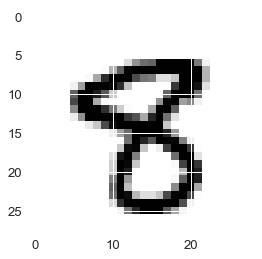

In [288]:
row_num = np.random.randint(60000)
print(ytrain[row_num])
plt.imshow(xtrain[row_num], cmap = "gray_r")

Before we begin, we must normalize the data. Each training element will be between 0 and 1. The test sample is normalized based on the training sample.

In [4]:
xtrain = (xtrain - xtrain.min()) / (xtrain.max() - xtrain.min())
xtest = (xtest - xtrain.min()) / (xtrain.max() - xtrain.min())

## Model 1 - Single Layer Softmax

Many models begin by flattening the input: The 28x28 matrix is converted to a vector of length 784. 

Every model will end by softmax: The probabilities of the image belonging to each class.

In model 1, this is all that is done.

In [163]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

Keras models require a compile step to specify optimization method, loss function, etc.

In [164]:
model1.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Keras lets us specify our validation split, batch size, and number of epochs.

In [165]:
model1.fit(xtrain, ytrain, validation_split=.1, batch_size=1000, epochs=5)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 1s 21us/sample - loss: 1.5065 - acc: 0.5976 - val_loss: 0.9001 - val_acc: 0.8375
Epoch 2/5
54000/54000 [==============================] - 1s 10us/sample - loss: 0.7929 - acc: 0.8245 - val_loss: 0.5872 - val_acc: 0.8835
Epoch 3/5
54000/54000 [==============================] - 0s 9us/sample - loss: 0.6010 - acc: 0.8589 - val_loss: 0.4715 - val_acc: 0.8992
Epoch 4/5
54000/54000 [==============================] - 1s 10us/sample - loss: 0.5132 - acc: 0.8750 - val_loss: 0.4103 - val_acc: 0.9077
Epoch 5/5
54000/54000 [==============================] - 1s 10us/sample - loss: 0.4617 - acc: 0.8836 - val_loss: 0.3731 - val_acc: 0.9120


Now we can evaluate the fit on our test sample.

In [166]:
test_loss1, test_acc1 = model1.evaluate(xtest, ytest)
print("Loss: ", test_loss1)
print("Acc: ", test_acc1)

10000/10000 [==============================] - 1s 67us/sample - loss: 1.6542 - acc: 0.8952
Loss:  1.6542043101716517
Acc:  0.8952


And using sklearn and seaborn, we can visualize the accuracy.

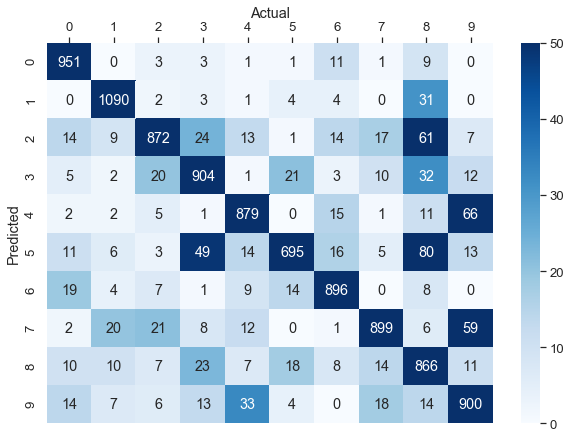

In [299]:
ypred1 = model1.predict_classes(xtest)
cm1 = metrics.confusion_matrix(ytest, ypred1)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
ax = sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 50)
ax.set(xlabel='Actual', ylabel='Predicted')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

For this simple model, we can plot the weights for each class in a meaningul way.

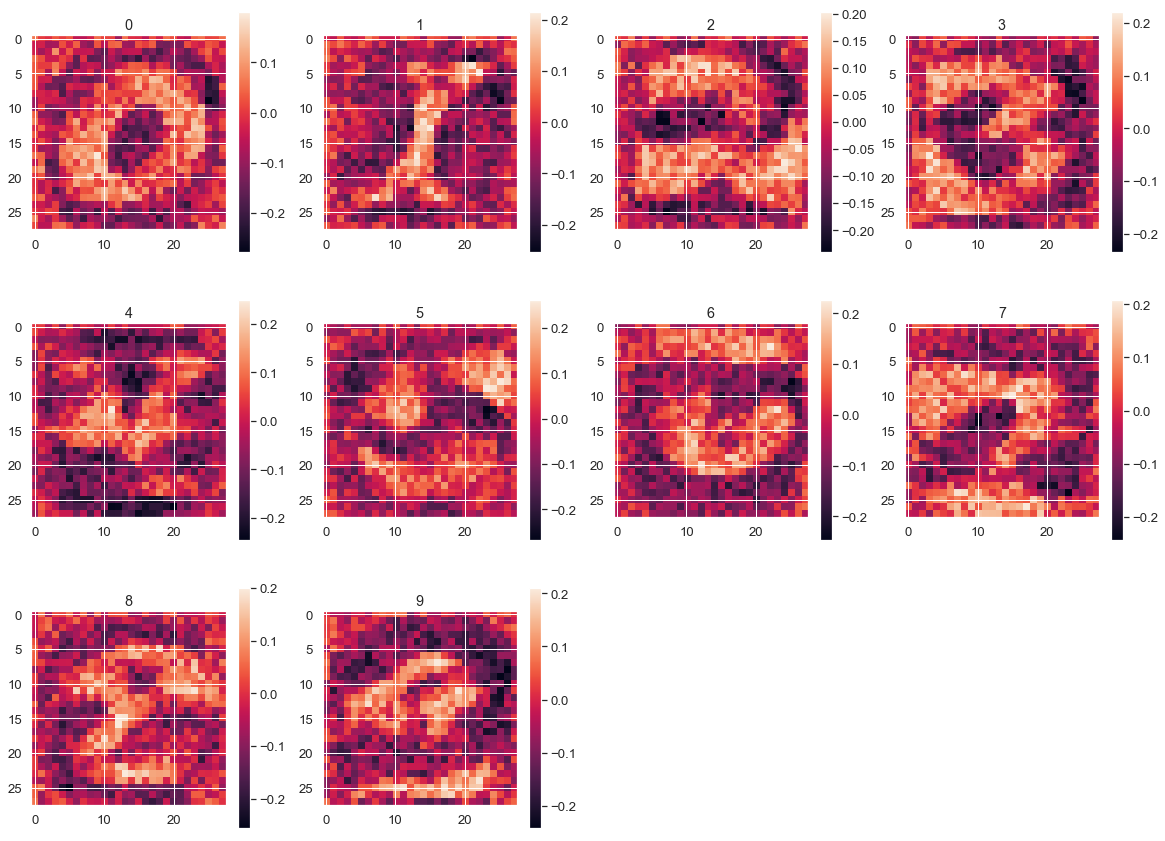

In [304]:
m1wts = model1.get_weights()
plt.figure(figsize = (20,15))
for i in range(0,10):
    plt.subplot(3,4,i+1).title.set_text(i)
    plt.imshow(m1wts[0][:,i].reshape(28,28))
    plt.colorbar()

### Hyperparameter Tuning

We try different combinations of L2 regularization and dropout, and select the best model.

In [131]:
models1 = {
    "model1_1" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model1_2" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(10, activation = tf.nn.softmax, kernel_regularizer=keras.regularizers.l2(1e-2))
        ])
    ],
    "model1_3" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(.8),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model1_4" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(.8),
        keras.layers.Dense(10, activation = tf.nn.softmax, kernel_regularizer=keras.regularizers.l2(1e-2))
        ])
    ]
}

In [132]:
for k in models1:
    # compile
    models1[k][0].compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    # train
    models1[k][0].fit(xtrain, ytrain, validation_split=.1, batch_size=1000, epochs=5, verbose=0)
    # evaluate
    models1[k].append(models1[k][0].evaluate(xtest, ytest))    

10000/10000 [==============================] - 1s 75us/sample - loss: 2.1332 - acc: 0.8715


In [137]:
for k in models1:
    print(k, ": Test Accuracy:",models1[k][1][1])

model1_1 : Test Accuracy: 0.8951
model1_2 : Test Accuracy: 0.8848
model1_3 : Test Accuracy: 0.875
model1_4 : Test Accuracy: 0.8715


We can visualize the effects that L2 regularization and droupout have on our weights.

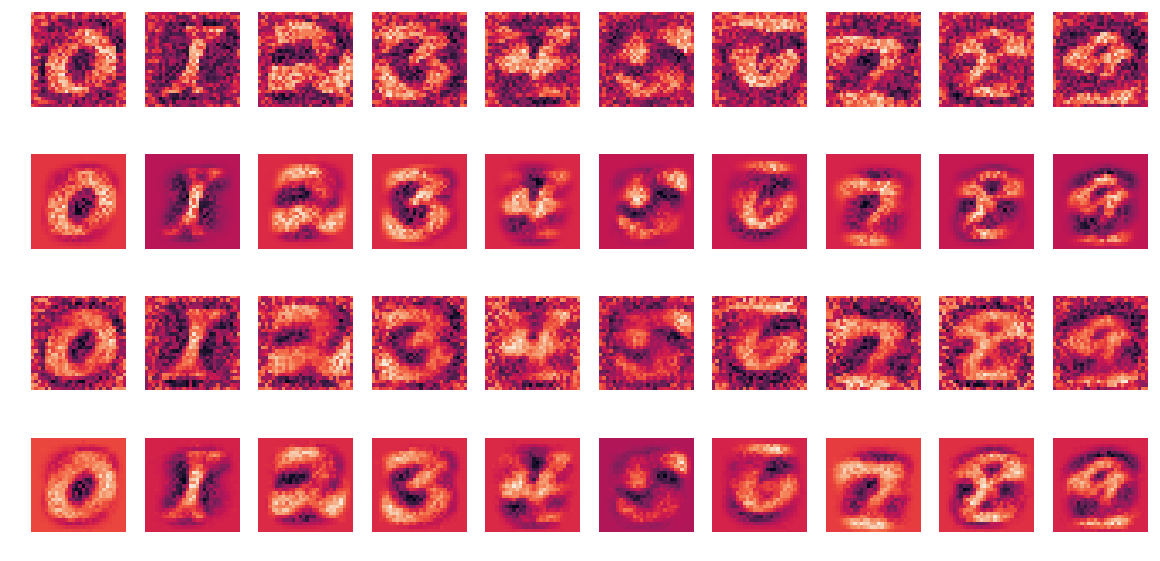

In [195]:
plt.figure(figsize = (20,10))

for i,k in enumerate(models1):
    m1wts = models1[k][0].get_weights()
    for j in range(0,10):
        plt.subplot(4,10,10*i+j+1)
        plt.imshow(m1wts[0][:,j].reshape(28,28))
        plt.axis('off')

## Model 2 - ReLu Hidden Layer

In model 2, we introduce a ReLu hidden layer.

In [225]:
models2 = {
    "model2_1" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model2_2" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model2_3" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model2_4" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ]
}

In [226]:
for k in models2:
    # compile
    models2[k][0].compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    # train
    models2[k][0].fit(xtrain, ytrain, validation_split=.1, batch_size=1000, epochs=5, verbose=0)
    # evaluate
    models2[k].append(models2[k][0].evaluate(xtest, ytest))  

10000/10000 [==============================] - 1s 93us/sample - loss: 0.6475 - acc: 0.9619


In [227]:
for k in models2:
    print(k, ": Test Accuracy:",models2[k][1][1])

model2_1 : Test Accuracy: 0.9618
model2_2 : Test Accuracy: 0.963
model2_3 : Test Accuracy: 0.963
model2_4 : Test Accuracy: 0.9619


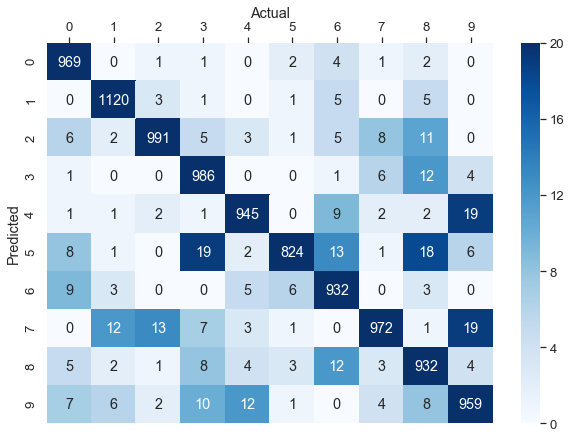

In [300]:
ypred2 = models2["model2_2"][0].predict_classes(xtest)
cm1 = metrics.confusion_matrix(ytest, ypred2)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
ax = sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 20)
ax.set(xlabel='Actual', ylabel='Predicted')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

## Model 3 - ReLu Hidden Layers

For model 3, lets add another ReLu layer, for a total of 2.

In [229]:
models3 = {
    "model3_1" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model3_2" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model3_3" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model3_4" : [
        keras.Sequential([
        keras.layers.Flatten(input_shape = (28,28)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ]
}

In [230]:
for k in models3:
    # compile
    models3[k][0].compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    # train
    models3[k][0].fit(xtrain, ytrain, validation_split=.1, batch_size=1000, epochs=5, verbose=0)
    # evaluate
    models3[k].append(models3[k][0].evaluate(xtest, ytest))  

10000/10000 [==============================] - 1s 97us/sample - loss: 0.4939 - acc: 0.9744


In [231]:
for k in models3:
    print(k, ": Test Accuracy:", models3[k][1][1])

model3_1 : Test Accuracy: 0.9743
model3_2 : Test Accuracy: 0.9735
model3_3 : Test Accuracy: 0.9757
model3_4 : Test Accuracy: 0.9744


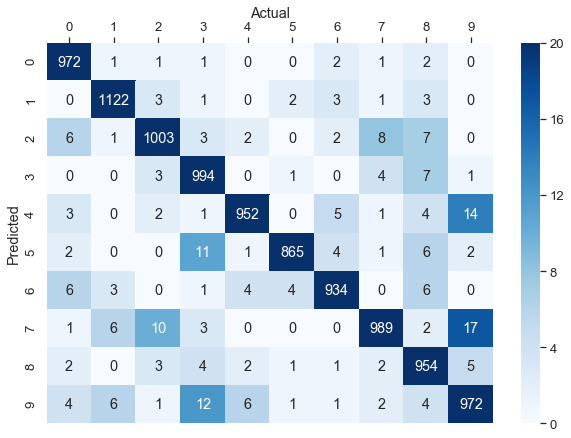

In [301]:
ypred3 = models3["model3_3"][0].predict_classes(xtest)
cm1 = metrics.confusion_matrix(ytest, ypred3)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
ax = sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 20)
ax.set(xlabel='Actual', ylabel='Predicted')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

## Model 4 - CNN

Finally, let's try a convolutional neural network.

In [233]:
models4 = {
    "model4_1" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model4_2" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model4_3" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model4_4" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ]
}

In [236]:
for k in models4:
    # compile
    models4[k][0].compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    # train
    models4[k][0].fit(xtrain.reshape(60000,28,28,1), ytrain, validation_split=.1, batch_size=1000, epochs=5, verbose=0)
    # evaluate
    models4[k].append(models4[k][0].evaluate(xtest.reshape(10000,28,28,1), ytest))  

10000/10000 [==============================] - 1s 102us/sample - loss: 0.2038 - acc: 0.9902


In [237]:
for k in models4:
    print(k, ": Test Accuracy:", models4[k][1][1])

model4_1 : Test Accuracy: 0.9844
model4_2 : Test Accuracy: 0.9847
model4_3 : Test Accuracy: 0.9874
model4_4 : Test Accuracy: 0.9902


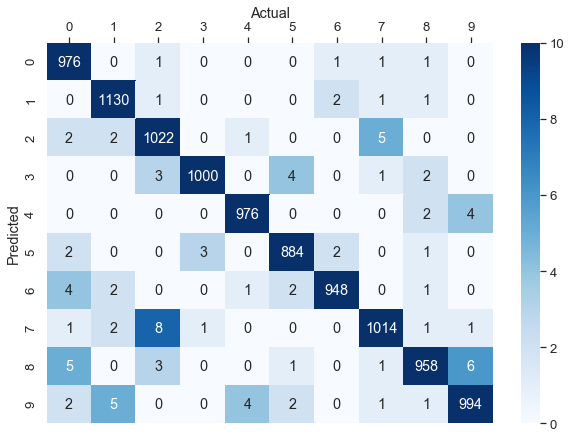

In [303]:
ypred4 = models4["model4_4"][0].predict_classes(xtest.reshape(10000,28,28,1))
cm1 = metrics.confusion_matrix(ytest, ypred4)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
ax = sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 10)
ax.set(xlabel='Actual', ylabel='Predicted')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

## Best Model

In [275]:
models = {**models1, **models2, **models3, **models4}
acc = {}
for k in models:
    acc[k] = models[k][1][1]
bestModel = max(acc, key=acc.get)
print("Best Accuracy Model:", bestModel)
print("with accuracy:", models[bestModel][1][1])

Best Accuracy Model: model4_4
with accuracy: 0.9902


Lets look at some examples of misclassifications.

In [276]:
ypred4 = models[bestModel][0].predict_classes(xtest.reshape(10000,28,28,1))
errors = list(np.where((ypred4 == ytest) == False)[0])

Actual: 2
Predicted: 7


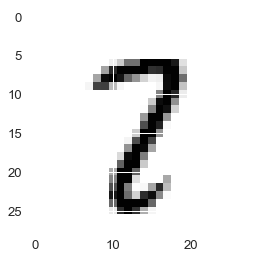

In [277]:
row_num = errors[0]
print("Actual:", ytest[row_num])
print("Predicted:", ypred4[row_num])
plt.imshow(xtest[row_num], cmap = "gray_r")

Actual: 5
Predicted: 3


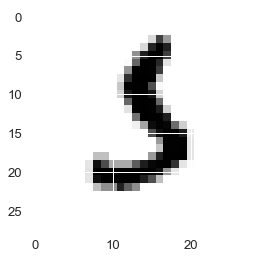

In [278]:
row_num = errors[1]
print("Actual:", ytest[row_num])
print("Predicted:", ypred4[row_num])
plt.imshow(xtest[row_num], cmap = "gray_r")

Actual: 6
Predicted: 0


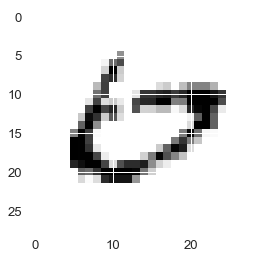

In [279]:
row_num = errors[2]
print("Actual:", ytest[row_num])
print("Predicted:", ypred4[row_num])
plt.imshow(xtest[row_num], cmap = "gray_r")

## Early Stopping

Let's take the architecture of the best model, set up some finer hyperparameter tuning, and let it train until the validation loss stops decreasing.

In [25]:
es = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 2,
    verbose = 0,
    mode = "auto"
)

In [26]:
models5 = {
    "model5_1" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model5_2" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model5_3" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ],
    "model5_4" : [
        keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(500, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation = tf.nn.softmax)
        ])
    ]
}

In [27]:
for k in models5:
    # compile
    models5[k][0].compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    # train
    models5[k][0].fit(xtrain.reshape(60000,28,28,1), 
                      ytrain, 
                      validation_split=.2, 
                      batch_size=1000, 
                      epochs=100, 
                      #verbose=0,
                      callbacks=[es])
    # evaluate
    models5[k].append(models5[k][0].evaluate(xtest.reshape(10000,28,28,1), ytest)) 

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 42us/sample - loss: 1.0720 - acc: 0.8448 - val_loss: 0.5039 - val_acc: 0.9578
Epoch 2/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.4077 - acc: 0.9578 - val_loss: 0.2857 - val_acc: 0.9751
Epoch 3/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.2569 - acc: 0.9704 - val_loss: 0.1986 - val_acc: 0.9796
Epoch 4/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1932 - acc: 0.9745 - val_loss: 0.1614 - val_acc: 0.9816
Epoch 5/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1630 - acc: 0.9774 - val_loss: 0.1312 - val_acc: 0.9849
Epoch 6/100
48000/48000 [==============================] - 1s 28us/sample - loss: 0.1435 - acc: 0.9795 - val_loss: 0.1263 - val_acc: 0.9839
Epoch 7/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1354 - acc: 0.9804 - val_l

Epoch 3/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1554 - acc: 0.9755 - val_loss: 0.1355 - val_acc: 0.9815
Epoch 4/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1260 - acc: 0.9820 - val_loss: 0.1179 - val_acc: 0.9840
Epoch 5/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1105 - acc: 0.9849 - val_loss: 0.1027 - val_acc: 0.9874
Epoch 6/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.0960 - acc: 0.9874 - val_loss: 0.0982 - val_acc: 0.9870
Epoch 7/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.0893 - acc: 0.9878 - val_loss: 0.0956 - val_acc: 0.9854
Epoch 8/100
48000/48000 [==============================] - 1s 28us/sample - loss: 0.0801 - acc: 0.9894 - val_loss: 0.0843 - val_acc: 0.9883
Epoch 9/100
48000/48000 [==============================] - 1s 27us/sample - loss: 0.0706 - acc: 0.9917 - val_loss: 0.0814 - val_acc: 0.9876
Epoch 10/100
48000/4

In [28]:
for k in models5:
    print(k, ": Test Accuracy:", models5[k][1][1])

model5_1 : Test Accuracy: 0.986
model5_2 : Test Accuracy: 0.9919
model5_3 : Test Accuracy: 0.987
model5_4 : Test Accuracy: 0.9886


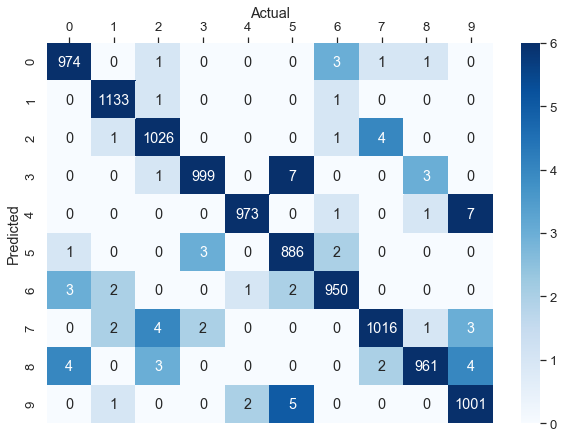

In [29]:
ypred5 = models5["model5_2"][0].predict_classes(xtest.reshape(10000,28,28,1))
cm1 = metrics.confusion_matrix(ytest, ypred5)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
ax = sn.heatmap(cm1, annot = True, fmt = 'd', cmap = "Blues", vmax = 6)
ax.set(xlabel='Actual', ylabel='Predicted')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 